In [8]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt

In [9]:
model = pm.Model()

assignment_to_focus = 1
switch_assignment = 0
num_papers = 10
p_paper_useful = 0.2 

def generate_probs(writing, evidence_level, friend_help):
    # Set up a PyTensor variable for the output probabilities
    # Start with the last condition, which will be the default if all other conditions fail
    probs = pt.switch(pt.eq(writing, 1) & pt.eq(evidence_level, 0) & pt.eq(friend_help, 0),
                      pt.as_tensor_variable([0.7, 0.3, 0.0]),
                      pt.switch(pt.eq(writing, 1) & pt.eq(evidence_level, 0) & pt.eq(friend_help, 1),
                                pt.as_tensor_variable([0.5, 0.5, 0.0]),
                                pt.switch(pt.eq(writing, 1) & pt.eq(evidence_level, 1) & pt.eq(friend_help, 0),
                                          pt.as_tensor_variable([0.2, 0.6, 0.2]),
                                          pt.switch(pt.eq(writing, 1) & pt.eq(evidence_level, 1) & pt.eq(friend_help, 1),
                                                    pt.as_tensor_variable([0.0, 0.7, 0.3]),
                                                    pt.switch(pt.eq(writing, 1) & pt.eq(evidence_level, 2) & pt.eq(friend_help, 0),
                                                              pt.as_tensor_variable([0.0, 0.5, 0.5]),
                                                              pt.switch(pt.eq(writing, 1) & pt.eq(evidence_level, 2) & pt.eq(friend_help, 1),
                                                                        pt.as_tensor_variable([0.0, 0.4, 0.6]),
                                                                        pt.switch(pt.eq(writing, 0) & pt.eq(evidence_level, 0) & pt.eq(friend_help, 0),
                                                                                  pt.as_tensor_variable([0.8, 0.2, 0.0]),
                                                                                  pt.switch(pt.eq(writing, 0) & pt.eq(evidence_level, 0) & pt.eq(friend_help, 1),
                                                                                            pt.as_tensor_variable([0.6, 0.4, 0.0]),
                                                                                            pt.switch(pt.eq(writing, 0) & pt.eq(evidence_level, 1) & pt.eq(friend_help, 0),
                                                                                                      pt.as_tensor_variable([0.3, 0.6, 0.1]),
                                                                                                      pt.switch(pt.eq(writing, 0) & pt.eq(evidence_level, 1) & pt.eq(friend_help, 1),
                                                                                                                pt.as_tensor_variable([0.1, 0.7, 0.2]),
                                                                                                                pt.switch(pt.eq(writing, 0) & pt.eq(evidence_level, 2) & pt.eq(friend_help, 0),
                                                                                                                          pt.as_tensor_variable([0.0, 0.6, 0.4]),
                                                                                                                          pt.as_tensor_variable([0.0, 0.5, 0.5]))))))))))))
    return probs


with model:

    good_models_for_a = pm.Bernoulli('good_models_for_a', p=0.7, shape=1)

    mu_model_improvement = pm.math.where(good_models_for_a, 7.5, 2.5)
    sigma_model_improvement = pm.math.where(good_models_for_a, 1, 0.5)
    
    a_model_improvement = pm.TruncatedNormal('model_improvement', mu=mu_model_improvement, sigma=sigma_model_improvement, lower=0, upper=20)
    a_model_improvement = pt.eq(assignment_to_focus, 0) * a_model_improvement

    preprocessing_improvment_p = pt.eq(switch_assignment, 0) * 0.4 + 0.4
    a_preprocessing_improved = pm.Bernoulli('a_preprocessing_improved', p=preprocessing_improvment_p, shape=1)
    a_preprocessing_improved = pm.math.where(pt.eq(a_preprocessing_improved, 0), 0.025, 0.05) #==> elicit

    a_final_score = pm.Deterministic('a_final_score', ((80+a_model_improvement)*(1+a_preprocessing_improved)-80)/20)

    b_evidence_amount = pm.Binomial('b_evidence_amount', n=num_papers, p=p_paper_useful, shape=1)
    b_evidence_level = pm.math.where(b_evidence_amount > 3, 
                                     pm.math.where(b_evidence_amount > 6, 2, 1), 
                                     0)

    b_evidence_level = pt.eq(assignment_to_focus, 1) * b_evidence_level

    p_good_writting = pt.eq(switch_assignment, 1) * 0.8 + 0.1 # 90 vs 10
    b_writting = pm.Bernoulli('b_writting', p=p_good_writting, shape=1)
    b_friend_help = pm.Bernoulli('b_friend_help', p=0.4, shape=1)

    b_final_score = pm.Categorical('b_final_score', p=generate_probs(b_writting, b_evidence_level, b_friend_help))

    usual_sleeping_time = pm.Normal('usual_sleeping_time', mu=8, sigma=1)
    first_choice = 0 if assignment_to_focus != 2 else 1
    actual_sleeping_time = pm.Deterministic('actual_sleeping_time', usual_sleeping_time - 2 * first_choice) 

    U_a = pm.Deterministic('U_a', (0.5 * np.tanh(0.05 * (a_final_score - 60)) + 0.5))
    U_b = pm.Deterministic('U_b', (0.5 * np.tanh(0.05 * (b_final_score - 60)) + 0.5))
    
    sleep_score = pm.math.switch(actual_sleeping_time < 6, 0,
                pm.math.switch(actual_sleeping_time > 8, 1,
                0.5 * actual_sleeping_time - 5))
    U_sleep = pm.Deterministic('U_sleep', sleep_score)

    U_score = pm.Deterministic('U_score', 0.4 * U_a + 0.2 * U_b + 0.3 * U_sleep + 0.1 * U_a * U_b * U_sleep)

TypeError: 'module' object is not callable

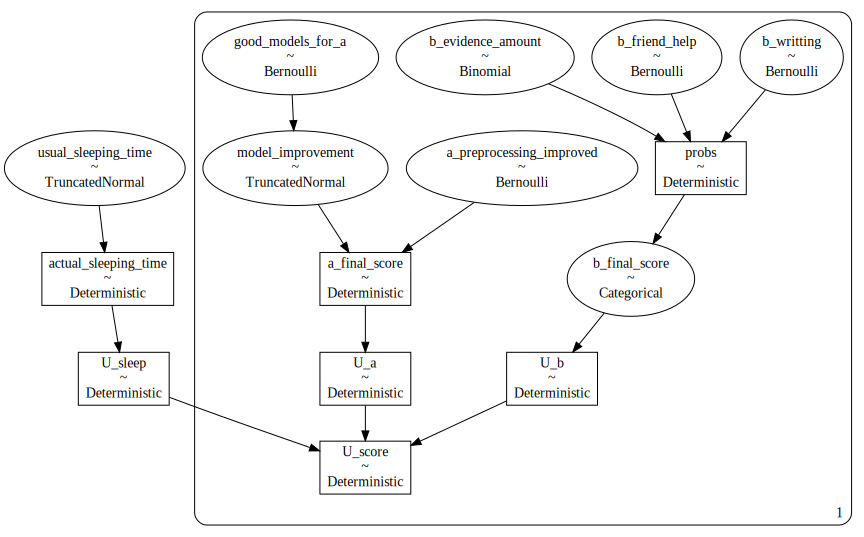

In [24]:
pm.model_to_graphviz(model)

In [32]:
with model:
    trace = pm.sample(draws= 20000,tune=1000, chains=2, random_seed=0)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [good_models_for_a, a_preprocessing_improved]
>NUTS: [model_improvement, a_bonus]
>Metropolis: [b_evidence_amount]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
good_models_for_a[0],0.566,0.496,0.000,1.000,0.076,0.054,42.0,42.0,1.03
model_improvement[0],5.333,2.615,1.652,8.980,0.380,0.271,67.0,817.0,1.02
b_evidence_amount[0],2.001,1.244,0.000,4.000,0.013,0.010,8886.0,9077.0,1.00
a_preprocessing_improved[0],0.799,0.400,0.000,1.000,0.002,0.002,34925.0,34925.0,1.00
a_bonus[0],0.090,0.459,-0.768,1.006,0.003,0.003,33837.0,24020.0,1.00
b_final_score[0],0.118,0.327,0.000,1.000,0.003,0.002,8981.0,9054.0,1.00
a_final_score[0],0.144,0.735,-1.228,1.610,0.004,0.004,33837.0,24020.0,1.00
U[0],0.262,0.805,-1.229,1.848,0.005,0.004,24152.0,21114.0,1.00


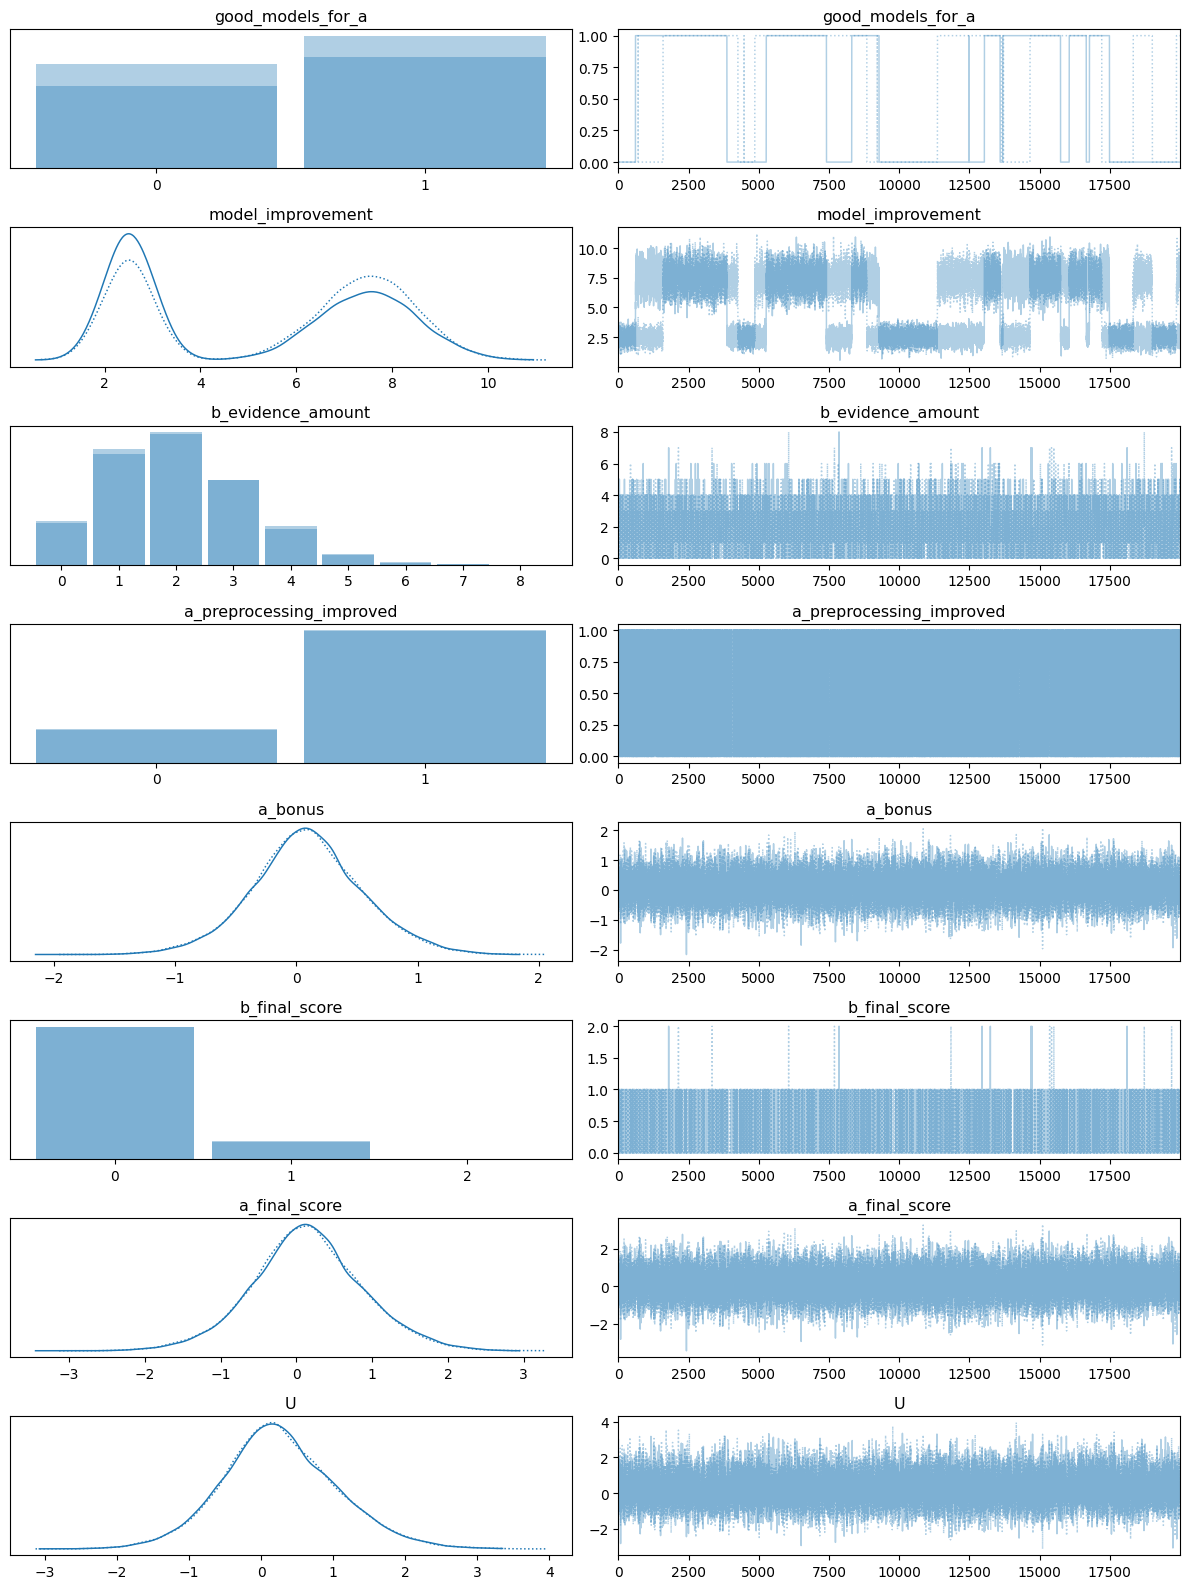

In [33]:
with model:
    display(az.summary(trace))
    az.plot_trace(trace)
    plt.tight_layout()

In [34]:
(trace['posterior']['U']).to_numpy().mean()

0.2619787583355876